In [26]:
import numpy as np
from matplotlib import pyplot as plt
from py import opt, read, hypergraph
from py.utils import *
import matplotlib.patches as patches

from scipy.stats import rankdata

from py.community import *

import networkx as nx

from scipy.linalg import eigh

data = 'contact-primary-school'
path = data + '/' + data + '-'

In [27]:
# t_min = 1386230122
t_min = 0

C = read.read_data(data, t_min = t_min)
C = hypergraph.hypergraph(C)
G = hypergraph.projected_graph(C, as_hyper = True)
n = G.n
d = G.node_degrees()
# d_ = np.sort(d)

In [28]:
b = opt.compute_b(d)

round 0, current error = 1396137.2314
round 1, current error = 1309915.0446
round 2, current error = 1199464.0314
round 3, current error = 1047617.408
round 4, current error = 419679.9533
round 5, current error = 1522.8372
round 6, current error = 87.8881
round 7, current error = 0.5984
round 8, current error = 0.2656
round 9, current error = 0.2671


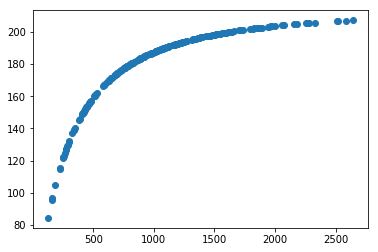

In [29]:
plt.scatter(d, b)

In [30]:
A = adjacency_matrix(G)

W = W_from_b(b)
B = A - W

W_NG = np.outer(d, d)/d.sum()
np.fill_diagonal(W_NG, 0)
B_NG = A - W_NG

# Mutual Information Comparisons

In [31]:
# def test_suite(k, W1, W2, n_reps = 100):
#     ell1, Q1 = find_best_clustering(A, W1, k,  n_reps = n_reps) 
#     ell2, Q2 = find_best_clustering(A, W2, k,  n_reps = n_reps) 
#     return(MI(ell1, ell2, normalize = True, return_joint = False))

In [32]:
# n_rounds = 100

# k_min = 2
# k_max = 11

# v = np.array([[test_suite(k, W, W_NG, 50) for k in range(k_min, k_max)] for j in range(n_rounds)])
# v_null1 = np.array([[test_suite(k, W_NG, W_NG, 50) for k in range(k_min, k_max)] for j in range(n_rounds)])
# # v_null2 = np.array([[test_suite(k, B, B, 10)[0] for k in range(2, k_max)] for j in range(n_rounds)])

In [33]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# bp1 = ax.boxplot(v, 
#                  flierprops = {'markeredgecolor' : 'darkred'},
#                 positions = 2*np.arange(k_min, k_max) - .3)
# for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#     plt.setp(bp1[element], color = 'darkred', linewidth = 1.5)
# bp2 = ax.boxplot(v_null1, 
#                  flierprops = {'markeredgecolor' : 'slategrey'},
#                  positions = 2*np.arange(k_min, k_max) + .3
#                 )
# for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#     plt.setp(bp2[element], color = 'slategrey', linewidth = 1.5)

# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Comparison', 'Null'], loc='lower right')

# ax.set(ylabel = 'NMI', xlabel = r'$k$', ylim = (0,1.1))
# labs = ax.set_xticklabels(range(k_min,k_max))

# plt.savefig('../../Downloads/modularity_boxplot.pdf')

Do another boxplot with modularities. Possibly both of them should be measured on the NG modularity matrix for comparability.  

# Direct Modularity Comparisons

In [34]:
k = 10

def compare_modularities(k):

    ell1, Q1 = find_best_clustering(A, W, k, n_reps = 50) 
    ell2, Q2 = find_best_clustering(A, W_NG, k, n_reps = 50) 

    Z1 = one_hot(ell1)
    Z2 = one_hot(ell2)

    straight1 = modularity(A, W, Z1)
    straight2 = modularity(A, W_NG, Z2)
    cross1 = modularity(A, W, Z2)
    cross2 = modularity(A, W_NG, Z1)
    
    return(np.array([straight1, cross2, cross1, straight2]))

In [35]:
[compare_modularities(k) for k in range(2, 10)]

[array([0.42829748, 0.43067892, 0.42829748, 0.43067892]),
 array([0.54319494, 0.55197417, 0.54094501, 0.55005473]),
 array([0.60705529, 0.61484558, 0.60607658, 0.61386036]),
 array([0.63673988, 0.64284301, 0.6292342 , 0.63586728]),
 array([0.63958813, 0.64559735, 0.63570195, 0.64184089]),
 array([0.63799945, 0.64397637, 0.64596987, 0.65266061]),
 array([0.638147  , 0.64380718, 0.64116867, 0.64822708]),
 array([0.65488866, 0.66121822, 0.6537858 , 0.66047485])]

In [36]:
def modularity_suite(k, A, W, n_reps = 50, n_rounds = 100, cross = None):
    Q = [find_best_clustering(A, W, k, n_reps)[1] for i in range(n_rounds)]
    return(Q)

In [37]:
k_min = 2
k_max = 11

n_rounds = 100

v = np.array([modularity_suite(k, A, W, n_reps = 50, n_rounds = 100) for k in range(k_min, k_max)])
v_NG = np.array([modularity_suite(k, A, W_NG, n_reps = 50, n_rounds = 100) for k in range(k_min, k_max)])

In [38]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# x_axis = np.arange(k_min, k_max)

# sig_mul = 2

# sig = np.sqrt(np.var(v_NG, axis = 1))
# mu = v_NG.mean(axis = 1)
# plt.plot(x_axis, mu, label = 'Zeroth Order', color = 'slategrey')
# plt.fill_between(x_axis, mu + sig_mul*sig, mu-sig_mul*sig, alpha = .5, color = 'slategrey')


# sig = np.sqrt(np.var(v, axis = 1))
# mu = v.mean(axis = 1)
# plt.plot(x_axis, mu, label = 'First Order', color = 'darkred')
# plt.fill_between(x_axis, mu + sig_mul*sig, mu-sig_mul*sig, alpha = .5, color = 'darkred')


# ax.set(xlabel = r'Number of communities $k$',
#        ylabel = r'Modularity $Q$')

# ax.legend(loc = 'lower right')

# Modularity Example

In [39]:
k = 8

num_unique1 = 1
num_unique2 = 2
# while num_unique1 != num_unique2:
#     print('trying')
ell1, Q1 = find_best_clustering(A, W, k, 500)
num_unique1 = len(np.unique(ell1))
ell2, Q2 = find_best_clustering(A, W_NG, k, 500)
num_unique2 = len(np.unique(ell2))

sig1 = np.sqrt(np.var(one_hot(ell1).sum(axis = 0)))
sig2 = np.sqrt(np.var(one_hot(ell2).sum(axis = 0)))

In [40]:
def reorder_labels(x):
    counts = np.bincount(x)
    lookup = np.argsort(np.argsort(-counts))
    return(np.array([lookup[i] for i in x]).astype(int))

In [41]:
ell1 = reorder_labels(ell1.astype(int))
ell2 = reorder_labels(ell2.astype(int))

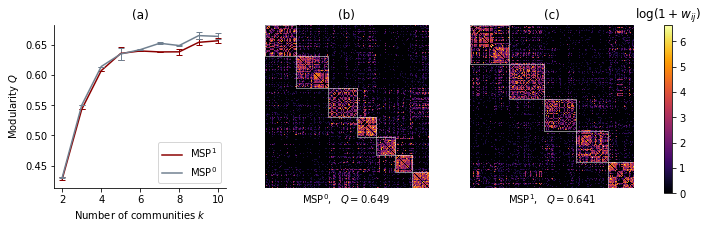

In [42]:
fig = plt.figure(figsize = (12, 3))


ax3 = fig.add_subplot(131)

x_axis = np.arange(k_min, k_max)

sig_mul = 2

sig = np.sqrt(np.var(v, axis = 1))
mu = v.mean(axis = 1)
ax3.plot(x_axis, mu, label = '$\mathrm{MSP}^1$', color = 'darkred')
ax3.errorbar(x_axis, mu, yerr = sig_mul*sig, fmt = 'none', color = 'darkred', elinewidth=1, capsize = 3)
# ax3.fill_between(x_axis, mu + sig_mul*sig, mu-sig_mul*sig, alpha = .4, color = 'darkred')


sig = np.sqrt(np.var(v_NG, axis = 1))
mu = v_NG.mean(axis = 1)
ax3.plot(x_axis, mu, label = '$\mathrm{MSP}^0$', color = 'slategrey')
ax3.errorbar(x_axis, mu, yerr = sig_mul*sig, fmt = 'none', color = 'slategrey', elinewidth=1, capsize = 3)

# plt.fill_between(x_axis, mu + sig_mul*sig, mu-sig_mul*sig, alpha = .4, color = 'slategrey')


ax3.set(xlabel = r'Number of communities $k$',
       ylabel = r'Modularity $Q$',
       title = '(a)')

ax3.legend(loc = 'lower right')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)


ax = fig.add_subplot(133)

ax.imshow(degree_sort(np.log(1+A), ell1), cmap = 'inferno', interpolation = 'nearest')

# nx.draw_networkx_nodes(g, pos = pos, node_color = ell, cmap = 'jet', node_size = 10, ax = ax)
# nx.draw_networkx_edges(g, pos = pos, edge_color = 'grey', alpha = .1, ax = ax)
ax.set(title = '(c)' ,
       xlabel = r'$\mathrm{MSP}^1$, $\;$ $Q = $' + str(round(Q1, 3)))

sig = np.sqrt(np.var(one_hot(ell2).sum(axis = 0)))
ax2 = fig.add_subplot(132)
im = ax2.imshow(degree_sort(np.log(1+A), ell2), cmap = 'inferno', interpolation = 'nearest')

# nx.draw_networkx_nodes(g, pos = pos, node_color = ell, cmap = 'jet', node_size = 10, ax = ax2)
# nx.draw_networkx_edges(g, pos = pos, edge_color = 'grey', alpha = .1, ax = ax2)
title = ax2.set(title = '(b)',
        xlabel = r'$\mathrm{MSP}^{0}$, $\;$ $Q = $' + str(round(Q2, 3)))

ix1 = np.array([0,0])
ix2 = np.array([0,0])

for i in np.unique(ell1):
    j = (ell1 == i).sum()
    rect = patches.Rectangle(ix1-.5,j,j,linewidth=.5,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
    ix1 += np.array([j,j])

for i in np.unique(ell2):    
    j = (ell2 == i).sum()
    rect = patches.Rectangle(ix2-.5,j,j,linewidth=.5,edgecolor='w',facecolor='none')
    ax2.add_patch(rect)
    ix2 += np.array([j,j])


for x in [ax, ax2]:
    x.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        right=False,
        left=False,
        labelbottom=False,
        labelleft=False,
        length = 0)

for AX in [ax, ax2]:
    for loc in ['top', 'right', 'bottom', 'left']:
        AX.spines[loc].set_visible(False)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.1, 0.01, 0.78])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar_ax.set(title = '$\log (1 + w_{ij})$')
plt.savefig('../../Downloads/modularity_primary_school.pdf',bbox_inches = 'tight')

In [43]:
print(modularity(A, W_NG, one_hot(ell1)), modularity(A, W, one_hot(ell1)))

print(modularity(A, W_NG, one_hot(ell2)), modularity(A, W, one_hot(ell2)))

0.6469081703180837 0.6413420715897818
0.648697224522868 0.6418394572627769


In [44]:
num_unique1

5

In [45]:
num_unique2

7